
## Study on ReLU polynomial approximations

This notebook studies ReLU approximations performed using Chebyshev nodes

### Importing libraries

The *numpy* library will be useful as it will help us simulate SIMD computations. We also use *math* to compute logarithms and *matplotlib* to plot some numbers

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy import polynomial as P
from enum import Enum

Defining a class to handle Remez approximations

In [2]:
class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func

        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        self.roots = f
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]

    def eval(self, x):
        a,b = self.a, self.b
        #assert(a <= x <= b)
        y = (2.0 * x - a - b) * (1.0 / (b - a))
        y2 = 2.0 * y
        (d, dd) = (self.c[-1], 0)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:            # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + cj, d)
        return y * d - dd + 0.5 * self.c[0]   # Last step is different
    
def relu(x):
    return np.maximum(0, x)

## Defining primitive functions

In [3]:
def add(a, b):
    """
    Adds two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise sum of input arrays.
    """
    return np.add(a, b)

def add_many(values):
    """
    Sums up multiple arrays contained in the values list.

    Parameters:
    values (list of array-like): List containing arrays to be summed.

    Returns:
    numpy.ndarray: Sum of all arrays in the values list.
    """
    res = np.zeros(len(values[0]), dtype=int)
    for value in values:
        res = add(res, value)
    return res

def sub(a, b):
    """
    Subtracts one array from another element-wise.

    Parameters:
    a (array-like): The array to be subtracted from.
    b (array-like): The array to subtract.

    Returns:
    numpy.ndarray: Element-wise difference of the two input arrays.
    """
    return np.add(a, -b)

def mul(a, b):
    """
    Multiplies two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise product of input arrays.
    """
    return np.multiply(a, b)

def mask(a, index):
    """
    Masks elements of array a at the specified index with 1 and multiplies with the array.

    Parameters:
    a (array-like): The input array.
    index (int): Index to be masked.

    Returns:
    numpy.ndarray: Array with specified index masked with 1.
    """
    mask_vector = np.zeros(len(a), dtype=int)
    mask_vector[index] = 1
    return mul(a, mask_vector)

def rot(a, index):
    """
    Rotates the array to the left by the specified number of positions.

    Parameters:
    a (array-like): The input array.
    index (int): Number of positions to rotate the array to the left.

    Returns:
    numpy.ndarray: Array rotated to the left by the specified number of positions.
    """
    return np.roll(a, -index)

def f_min(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(min(a[i], b[i]))
    return np.array(ans)

def f_min_remez(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(a[i] - poly_relu_remez.eval(a[i] - b[i]))
    return np.array(ans)

def f_min_cheby(a, b):
    """
    Computes the element-wise minimum of two arrays using the
    coefficients obtained by Chebyshev interpolation

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    return sub(a, np.vectorize(poly_relu_cheby.eval)(sub(a, b)))

def f_min_remez(a, b):
    """
    Computes the element-wise minimum of two arrays using the
    coefficients obtained by Remez algorithm

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    return sub(a, np.vectorize(poly_relu_remez.eval_cheby_series)(sub(a, b)))

Error functions

In [4]:
def l1norm(real, approx):
    return sum(abs(np.array(real) -np.array(approx))) / len(real)

def l2norm(real, approx):
    return np.sqrt((sum(np.array(real) - np.array(approx)) ** 2) / len(real))

def linfnorm(real, approx):
    return max(abs(np.array(real) - np.array(approx)))

def precision_bits(real, approx):
    return -math.log2(linfnorm(real, approx))

### 1) The errors

We want to study the distribution of errors, with respect to the chosen degree $d$

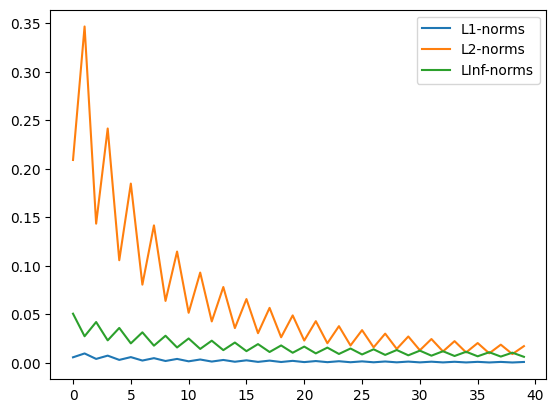

In [5]:
l1_norms = []
l2_norms = []
linf_norms = []

for degree in range(10, 50):
    poly_relu_cheby = Chebyshev(-1, 1, degree, relu)

    space = np.linspace(-1, 1, 10000)

    real = relu(space)
    obtained = poly_relu_cheby.eval(space)

    l1_norms.append(l1norm(real, obtained))
    l2_norms.append(l2norm(real, obtained))
    linf_norms.append(linfnorm(real, obtained))

plt.plot(l1_norms, label = "L1-norms")
plt.plot(l2_norms, label = "L2-norms")
plt.plot(linf_norms, label = "LInf-norms")
plt.legend()

## Larger accuracies with respect to (Lee *et al*, 2022):

In [11]:
#Consuming 5 levels

poly_relu_cheby = Chebyshev(-1, 1, 27, relu)
space = np.linspace(-1, 1, 100000)

real = relu(space)
approx = np.vectorize(poly_relu_cheby.eval)(space)

precision_bits(real, approx)

6.49768709883271

In [12]:
#Consuming 6 levels

poly_relu_cheby = Chebyshev(-1, 1, 59, relu)
space = np.linspace(-1, 1, 100000)

real = relu(space)
approx = np.vectorize(poly_relu_cheby.eval)(space)

precision_bits(real, approx)

7.626683539454014

In [13]:
#Consuming 7 levels

poly_relu_cheby = Chebyshev(-1, 1, 119, relu)
space = np.linspace(-1, 1, 100000)

real = relu(space)
approx = np.vectorize(poly_relu_cheby.eval)(space)

precision_bits(real, approx)

8.639106584801379

In [9]:
#Consuming 8 levels

poly_relu_cheby = Chebyshev(-1, 1, 245, relu)
space = np.linspace(-1, 1, 100000)

real = relu(space)
approx = np.vectorize(poly_relu_cheby.eval)(space)

precision_bits(real, approx)

9.68098953671094

In [15]:
#Consuming 9 levels

poly_relu_cheby = Chebyshev(-1, 1, 495, relu)
space = np.linspace(-1, 1, 100000)

real = relu(space)
approx = np.vectorize(poly_relu_cheby.eval)(space)

precision_bits(real, approx)

10.69566222500027

## 2) The ranges

Since polynomial approximations does not behave exactly as the non-linear counterpart, we have to make sure that the co-domain of the approximations of ReLU$(x)$ is $[0, 1]$

In [11]:
ranges = {}
i = 0

for degree in range(27, 1008):
    poly_relu_cheby = Chebyshev(-1, 1, degree, relu)

    space = np.linspace(-1, 1, 100000)

    real = relu(space)
    obtained = poly_relu_cheby.eval(space)

    ranges[i] = [degree, min(obtained), max(obtained), max(obtained) - min(obtained)]
    i = i + 1

Let's observe the co-domains

In [11]:
keys = list(ranges.keys())

values = list(ranges.values())

df = pd.DataFrame(values, columns=['Degree', 'Min', 'Max', 'Range'], index=keys)

ranges_df = df.copy(deep = True)
ranges_df

,Degree,Min,Max,Range
0,27,-0.011066,1.001075,1.012141
1,28,-0.002793,1.000056,1.002849
2,29,-0.010302,0.999068,1.009370
3,30,-0.002604,0.999954,1.002559
4,31,-0.009636,1.000816,1.010452
...,...,...,...,...
976,1003,-0.000298,1.000001,1.000298
977,1004,-0.000077,1.000000,1.000077
978,1005,-0.000297,0.999999,1.000296
979,1006,-0.000077,1.000000,1.000077


They need to be corrected!

In [12]:
def correct_approx_output(value, degree):
    m = codomainsdf.loc[ranges_df['Degree'] == degree]['Min'].item()
    r = codomainsdf.loc[ranges_df['Degree'] == degree]['Range'].item()
    return (value - m) / r

In [240]:
ranges = {}

i = 0

for degree in range(27, 496):
    poly_relu_cheby = Chebyshev(-1, 1, degree, relu)

    space = np.linspace(-1, 1, 10000)

    real = relu(space)
    obtained = poly_relu_cheby.eval(space)
    obtained = correct_approx_output(obtained, degree)

    ranges[i] = [degree, min(obtained), max(obtained), max(obtained) - min(obtained)]
    i = i + 1

In [241]:
keys = list(ranges.keys())

values = list(ranges.values())

df = pd.DataFrame(values, columns=['Degree', 'Min', 'Max', 'Range'], index=keys)

df

,Degree,Min,Max,Range
0,27,0.0,1.0,1.0
1,28,0.0,1.0,1.0
2,29,0.0,1.0,1.0
3,30,0.0,1.0,1.0
4,31,0.0,1.0,1.0
5,32,0.0,1.0,1.0
6,33,0.0,1.0,1.0
7,34,0.0,1.0,1.0
8,35,0.0,1.0,1.0
9,36,0.0,1.0,1.0


Now they are corrected in $[0, 1]$. How much did it cost in terms of precision?

In [383]:
errors = {}
i = 0

for degree in range(27, 1008):
    poly_relu_cheby = Chebyshev(-1, 1, degree, relu)

    space = np.linspace(-1, 1, 10000)

    real = relu(space)
    
    obtained = poly_relu_cheby.eval(space)
    obtained_corrected = correct_approx_output(poly_relu_cheby.eval(space), degree)

    errors[i] = [degree, max(abs(real - obtained)), max(abs(real - obtained_corrected)), max(abs(real - obtained)) - max(abs(real - obtained_corrected))]
    i = i + 1

In [384]:
keys = list(errors.keys())

values = list(errors.values())

df = pd.DataFrame(values, columns=['Degree', 'Error raw', 'Error corrected', 'Precision loss'], index=keys)

df

,Degree,Error raw,Error corrected,Precision loss
0,27,0.011066,0.016304,-0.005238
1,28,0.017835,0.020570,-0.002735
2,29,0.010302,0.015216,-0.004914
3,30,0.016640,0.019195,-0.002555
4,31,0.009636,0.014214,-0.004579
5,32,0.015594,0.017989,-0.002395
6,33,0.009051,0.013378,-0.004327
7,34,0.014672,0.016928,-0.002256
8,35,0.008533,0.012600,-0.004067
9,36,0.013852,0.015983,-0.002131


This set of functions can be trivially written as CKKS homomorphic operations

Now we define the _swap_ function that will heavily be used throughout the evaluation of the Sorting Network

In [47]:
class MinEvaluation(Enum):
    PLAIN = 1
    CHEBYSHEV = 2,
    CHEBYSHEV_CORRECTED = 3

In [48]:
def swap_simd(a, delta, r = 0, s = 0, min_eval = MinEvaluation.PLAIN):    
    """
    Computes a parallel evaluation of a Sorting Network

    Parameters:
    a (array-like): Input array
    delta (int): The value of delta. In a sorting network, it specifies the "length of the arrows".
    r (int): The current round of the sorting network
    s (int): The current stage of the sorting network

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    rot_positive = rot(a, delta)
    rot_negative = rot(a, -delta)
    
    # This is the evaluation of the non-linear function
    
    if min_eval == MinEvaluation.PLAIN:
        f = f_min(a, rot_positive)
    elif min_eval == MinEvaluation.CHEBYSHEV:
        f = f_min_cheby(a, rot_positive)
    elif min_eval == MinEvaluation.CHEBYSHEV_CORRECTED:
        f = f_min_cheby(a, rot_positive)
        f = correct_approx_output(f, poly_degree)
            
    m1 = f
    m2 = sub(add(a, rot_negative), rot(f, -delta))
    m3 = sub(add(a, rot_positive), f)
    m4 = rot(f, -delta)
    
    masks = generate_masks(len(a), r, s)
    
    return add_many([mul(m1, masks[0]), 
                     mul(m2, masks[1]),
                     mul(m3, masks[2]),
                     mul(m4, masks[3])])

In [49]:
def generate_masks(length, r, s):
    """
    Da commentare
    """
    mask_1 = []
    mask_2 = []
    mask_3 = []
    mask_4 = []
    
    i = 0  
    
    while (i < length / (2 ** (r + 2))):
        
        for times in range(2 ** s):
            for j in range(2 ** r):
                # How many times do we consider m_1

                mask_1.append(1)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(0)

            for j in range(2 ** r):
                # How many times do we consider m_2

                mask_1.append(0)
                mask_2.append(1)
                mask_3.append(0)
                mask_4.append(0)
        
        if (i + 1) * 2 ** (s + r + 1) >= length:
            break
            
        for times in range(2 ** s):
            for j in range(2 ** (r)):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(1)
                mask_4.append(0)
                
            for j in range(2 ** r):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(1)
        
            
        if (i + 1) * 2 ** (s + r + 2) >= length:
            break
            
        i += 1
    
    return [mask_1, mask_2, mask_3, mask_4]

### Evaluating a Network

We sample a vector of $2^{6} = 64$ elements

In [44]:
n = 2 ** 12

a = np.arange(n) / n
np.random.shuffle(a)

a_copy = np.copy(a)
a.sort()

print("Generated a random array of {} values".format(n))

Generated a random array of 4096 values


Now we evaluate it using SIMD computations, in particular we will just use the _swap_simd_ function

In [45]:
poly_degree = 494
poly_relu_cheby = Chebyshev(-1, 1, poly_degree, relu)

In [46]:
vec = np.copy(a_copy)

for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, MinEvaluation.CHEBYSHEV)
#vec
print("Precision bits: {}".format(round(-math.log2(max(abs(sub(a, vec)))), 2)))

NameError: name 'swap_simd' is not defined

In [365]:
poly_degree = 495
poly_relu_cheby = Chebyshev(-1, 1, poly_degree, relu)

In [373]:
vec = np.copy(a_copy)

for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, MinEvaluation.CHEBYSHEV)
#vec
print("Precision bits: {}".format(round(-math.log2(max(abs(sub(a, vec)))), 2)))

/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_23855/3193638134.py:29: RuntimeWarning: overflow encountered in scalar multiply
  (d, dd) = (y2 * d - dd + cj, d)
/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_23855/3193638134.py:29: RuntimeWarning: invalid value encountered in scalar subtract
  (d, dd) = (y2 * d - dd + cj, d)


Precision bits: nan


### Approach 1: Scaling the input

In [392]:
poly_degree = 494
poly_relu_cheby = Chebyshev(-1, 1, poly_degree, relu)

In [393]:
vec = np.copy(a_copy) * 0.99

for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, MinEvaluation.CHEBYSHEV)
#vec
print("Precision bits: {}".format(round(-math.log2(max(abs(sub(a, vec)))), 2)))

Precision bits: 6.35


### Approach 2: Using CHEBYSHEV_CORRECTED

In [374]:
poly_degree = 494
poly_relu_cheby = Chebyshev(-1, 1, poly_degree, relu)

In [375]:
vec = np.copy(a_copy)

for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, MinEvaluation.CHEBYSHEV_CORRECTED)  
#vec
print("Precision bits: {}".format(round(-math.log2(max(abs(sub(a, vec)))), 2)))

Precision bits: 6.45


In [385]:
poly_degree = 1006
poly_relu_cheby = Chebyshev(-1, 1, poly_degree, relu)

In [386]:
vec = np.copy(a_copy)

for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, MinEvaluation.CHEBYSHEV_CORRECTED)  
#vec
print("Precision bits: {}".format(round(-math.log2(max(abs(sub(a, vec)))), 2)))

Precision bits: 7.45


In [55]:
n = 4

a = [0, 0.001, 0.002, 0.003]
np.random.shuffle(a)

a_copy = np.copy(a)
a.sort()

print("Generated a random array of {} values".format(n))

Generated a random array of 4 values


In [57]:
poly_relu_cheby = Chebyshev(-1, 1, 119, relu)
vec = np.copy(a_copy)

for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, MinEvaluation.CHEBYSHEV)  
#vec
print("Precision bits: {}".format(round(-math.log2(max(abs(sub(a, vec)))), 2)))

Precision bits: 9.49
